<a href="https://colab.research.google.com/github/James606240/NTUT_Test/blob/main/PD_CH5_05_10_Manifold_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# In-Depth: Manifold Learning

### P.465

### 流形學習(manifold learning, ML) 廣義來說包含了所有和幾何相關的機器學習理論[1]，其中主要的一個分支是低維嵌入(lo embedding)，目的是做資料降維(dimensionality reduction)、視覺化(data visualiw dimensionalzation)或分群(clustering)，這部分和統計的多變量分析比較相關[2]。統計中最基本的降維方法叫做主成分分析(Principal component analysis, PCA)，大多數多變量分析的課本都有提到，或者可以參考專書[3]。另一個常用於“相對性”資料的方法則是 multidimensional scaling(MDS)[4]。這兩種方式都是在指定的低維歐氏空間中盡可能重建原始資料分佈。

### 2000 年時，同一期《Science》上出現兩個新的 ML 演算法：Isomap[5] 與 Locally Linear Embedding(LLE)[6]。之後陸續有 Laplacian eigenmap(LE)[7]、Diffusion map(DM)[8]、t-SNE[9] 等方法。這些新方法和以往最大的差異在於假設資料具有流形的結構，因此採用非線性的嵌入法來研究資料的型態，亦即"學習流形(learn the manifold)"。

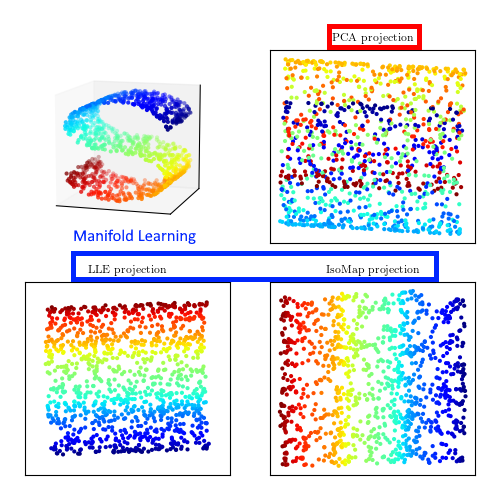

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

### P.466

## Manifold Learning: "HELLO"

To make these concepts more clear, let's start by generating some two-dimensional data that we can use to define a manifold.
Here is a function that will create data in the shape of the word "HELLO":

In [ ]:
def make_hello(N=1000, rseed=42):
    # Make a plot with "HELLO" text; save as PNG
    fig, ax = plt.subplots(figsize=(4, 1))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    ax.axis('off')
    ax.text(0.5, 0.4, 'HELLO', va='center', ha='center', weight='bold', size=85)
    fig.savefig('hello.png')
    plt.close(fig)
    
    # Open this PNG and draw random points from it
    from matplotlib.image import imread
    data = imread('hello.png')[::-1, :, 0].T
    rng = np.random.RandomState(rseed)
    X = rng.rand(4 * N, 2)
    i, j = (X * data.shape).astype(int).T
    mask = (data[i, j] < 1)
    X = X[mask]
    X[:, 0] *= (data.shape[0] / data.shape[1])
    X = X[:N]
    return X[np.argsort(X[:, 0])]

Let's call the function and visualize the resulting data:

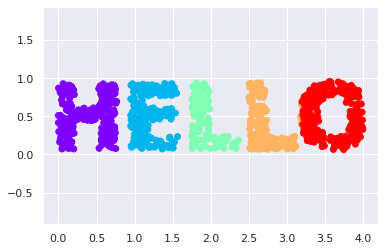

In [ ]:
X = make_hello(1000)
colorize = dict(c=X[:, 0], cmap=plt.cm.get_cmap('rainbow', 5))
plt.scatter(X[:, 0], X[:, 1], **colorize)
plt.axis('equal');

The output is two dimensional, and consists of points drawn in the shape of the word, "HELLO".
This data form will help us to see visually what these algorithms are doing.

### P.467

## Multidimensional Scaling (MDS)

Looking at data like this, we can see that the particular choice of *x* and *y* values of the dataset are not the most fundamental description of the data: we can scale, shrink, or rotate the data, and the "HELLO" will still be apparent.
For example, if we use a rotation matrix to rotate the data, the *x* and *y* values change, but the data is still fundamentally the same:

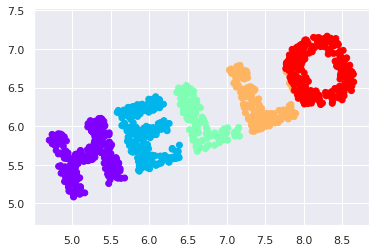

In [ ]:
def rotate(X, angle):
    theta = np.deg2rad(angle)
    R = [[np.cos(theta), np.sin(theta)],
         [-np.sin(theta), np.cos(theta)]]
    return np.dot(X, R)
    
X2 = rotate(X, 20) + 5
plt.scatter(X2[:, 0], X2[:, 1], **colorize)
plt.axis('equal');

### P.468

In [ ]:
from sklearn.metrics import pairwise_distances
D = pairwise_distances(X)
D.shape

(1000, 1000)

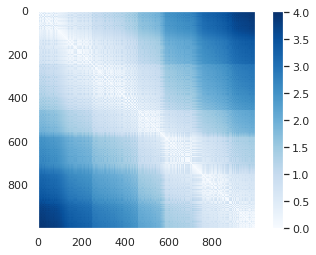

In [ ]:
plt.imshow(D, zorder=2, cmap='Blues', interpolation='nearest')
plt.colorbar();

### P.469

In [ ]:
D2 = pairwise_distances(X2)
np.allclose(D, D2)

True

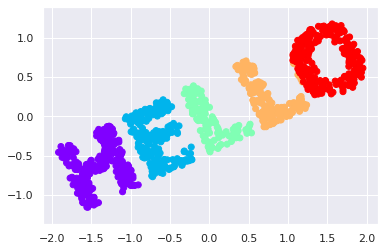

In [ ]:
from sklearn.manifold import MDS
model = MDS(n_components=2, dissimilarity='precomputed', random_state=1)
out = model.fit_transform(D)
plt.scatter(out[:, 0], out[:, 1], **colorize)
plt.axis('equal');

### P.470

## MDS as Manifold Learning

The usefulness of this becomes more apparent when we consider the fact that distance matrices can be computed from data in *any* dimension.
So, for example, instead of simply rotating the data in the two-dimensional plane, we can project it into three dimensions using the following function (essentially a three-dimensional generalization of the rotation matrix used earlier):

In [ ]:
def random_projection(X, dimension=3, rseed=42):
    assert dimension >= X.shape[1]
    rng = np.random.RandomState(rseed)
    C = rng.randn(dimension, dimension)
    e, V = np.linalg.eigh(np.dot(C, C.T))
    return np.dot(X, V[:X.shape[1]])
    
X3 = random_projection(X, 3)
X3.shape

(1000, 3)

Let's visualize these points to see what we're working with:

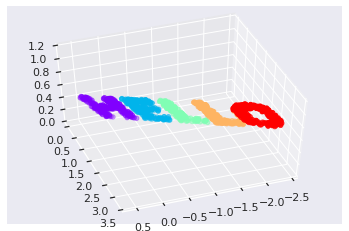

In [ ]:
from mpl_toolkits import mplot3d
ax = plt.axes(projection='3d')
ax.scatter3D(X3[:, 0], X3[:, 1], X3[:, 2],
             **colorize)
ax.view_init(azim=70, elev=50)

### P.471

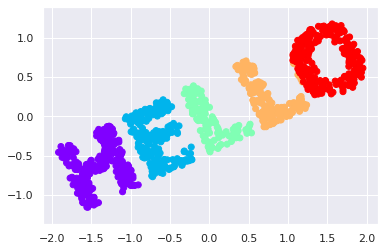

In [ ]:
model = MDS(n_components=2, random_state=1)
out3 = model.fit_transform(X3)
plt.scatter(out3[:, 0], out3[:, 1], **colorize)
plt.axis('equal');

### P.472

## Nonlinear Embeddings: Where MDS Fails

Our discussion thus far has considered *linear* embeddings, which essentially consist of rotations, translations, and scalings of data into higher-dimensional spaces.
Where MDS breaks down is when the embedding is nonlinear—that is, when it goes beyond this simple set of operations.
Consider the following embedding, which takes the input and contorts it into an "S" shape in three dimensions:

In [ ]:
def make_hello_s_curve(X):
    t = (X[:, 0] - 2) * 0.75 * np.pi
    x = np.sin(t)
    y = X[:, 1]
    z = np.sign(t) * (np.cos(t) - 1)
    return np.vstack((x, y, z)).T

XS = make_hello_s_curve(X)

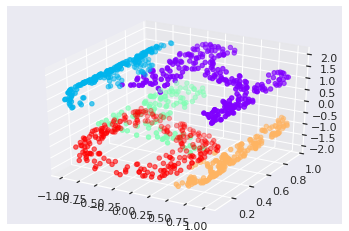

In [ ]:
from mpl_toolkits import mplot3d
ax = plt.axes(projection='3d')
ax.scatter3D(XS[:, 0], XS[:, 1], XS[:, 2],
             **colorize);

### P.473

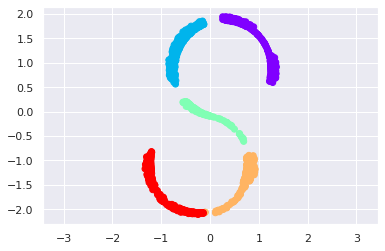

In [ ]:
from sklearn.manifold import MDS
model = MDS(n_components=2, random_state=2)
outS = model.fit_transform(XS)
plt.scatter(outS[:, 0], outS[:, 1], **colorize)
plt.axis('equal');

### P.473

## Nonlinear Manifolds: Locally Linear Embedding

How can we move forward here? Stepping back, we can see that the source of the problem is that MDS tries to preserve distances between faraway points when constructing the embedding.
But what if we instead modified the algorithm such that it only preserves distances between nearby points?
The resulting embedding would be closer to what we want.

Visually, we can think of it as illustrated in this figure:

### P.474

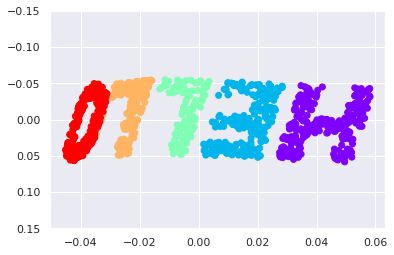

In [ ]:
from sklearn.manifold import LocallyLinearEmbedding
model = LocallyLinearEmbedding(n_neighbors=100, n_components=2, method='modified',
                               eigen_solver='dense')
out = model.fit_transform(XS)

fig, ax = plt.subplots()
ax.scatter(out[:, 0], out[:, 1], **colorize)
ax.set_ylim(0.15, -0.15);

### P.475

## Some Thoughts on Manifold Methods

Though this story and motivation is compelling, in practice manifold learning techniques tend to be finicky enough that they are rarely used for anything more than simple qualitative visualization of high-dimensional data.

The following are some of the particular challenges of manifold learning, which all contrast poorly with PCA:

- In manifold learning, there is no good framework for handling missing data. In contrast, there are straightforward iterative approaches for missing data in PCA.
- In manifold learning, the presence of noise in the data can "short-circuit" the manifold and drastically change the embedding. In contrast, PCA naturally filters noise from the most important components.
- The manifold embedding result is generally highly dependent on the number of neighbors chosen, and there is generally no solid quantitative way to choose an optimal number of neighbors. In contrast, PCA does not involve such a choice.
- In manifold learning, the globally optimal number of output dimensions is difficult to determine. In contrast, PCA lets you find the output dimension based on the explained variance.
- In manifold learning, the meaning of the embedded dimensions is not always clear. In PCA, the principal components have a very clear meaning.
- In manifold learning the computational expense of manifold methods scales as O[N^2] or O[N^3]. For PCA, there exist randomized approaches that are generally much faster (though see the [megaman](https://github.com/mmp2/megaman) package for some more scalable implementations of manifold learning).

With all that on the table, the only clear advantage of manifold learning methods over PCA is their ability to preserve nonlinear relationships in the data; for that reason I tend to explore data with manifold methods only after first exploring them with PCA.

Scikit-Learn implements several common variants of manifold learning beyond Isomap and LLE: the Scikit-Learn documentation has a [nice discussion and comparison of them](http://scikit-learn.org/stable/modules/manifold.html).
Based on my own experience, I would give the following recommendations:

- For toy problems such as the S-curve we saw before, locally linear embedding (LLE) and its variants (especially *modified LLE*), perform very well. This is implemented in ``sklearn.manifold.LocallyLinearEmbedding``.
- For high-dimensional data from real-world sources, LLE often produces poor results, and isometric mapping (IsoMap) seems to generally lead to more meaningful embeddings. This is implemented in ``sklearn.manifold.Isomap``
- For data that is highly clustered, *t-distributed stochastic neighbor embedding* (t-SNE) seems to work very well, though can be very slow compared to other methods. This is implemented in ``sklearn.manifold.TSNE``.

If you're interested in getting a feel for how these work, I'd suggest running each of the methods on the data in this section.

### P.476

## Example: Isomap on Faces

One place manifold learning is often used is in understanding the relationship between high-dimensional data points.
A common case of high-dimensional data is images: for example, a set of images with 1,000 pixels each can be thought of as a collection of points in 1,000 dimensions – the brightness of each pixel in each image defines the coordinate in that dimension.

Here let's apply Isomap on some faces data.
We will use the Labeled Faces in the Wild dataset, which we previously saw in [In-Depth: Support Vector Machines](05.07-Support-Vector-Machines.ipynb) and [In Depth: Principal Component Analysis](05.09-Principal-Component-Analysis.ipynb).
Running this command will download the data and cache it in your home directory for later use:

In [ ]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=30)
faces.data.shape

(2370, 2914)

We have 2,370 images, each with 2,914 pixels.
In other words, the images can be thought of as data points in a 2,914-dimensional space!

Let's quickly visualize several of these images to see what we're working with:

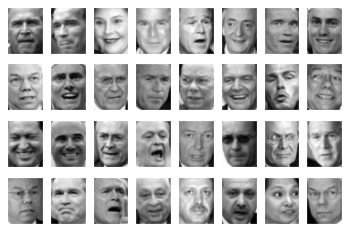

In [ ]:
fig, ax = plt.subplots(4, 8, subplot_kw=dict(xticks=[], yticks=[]))
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='gray')

We would like to plot a low-dimensional embedding of the 2,914-dimensional data to learn the fundamental relationships between the images.
One useful way to start is to compute a PCA, and examine the explained variance ratio, which will give us an idea of how many linear features are required to describe the data:

### P.477

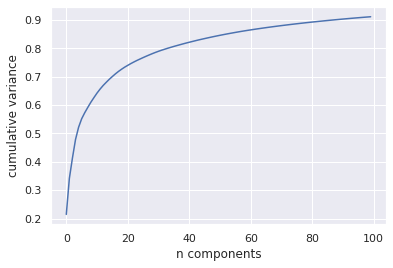

In [ ]:
from sklearn.decomposition import PCA
model = PCA(100).fit(faces.data)
plt.plot(np.cumsum(model.explained_variance_ratio_))
plt.xlabel('n components')
plt.ylabel('cumulative variance');

In [ ]:
from sklearn.manifold import Isomap
model = Isomap(n_components=2)
proj = model.fit_transform(faces.data)
proj.shape

(2370, 2)

In [ ]:
from matplotlib import offsetbox

def plot_components(data, model, images=None, ax=None,
                    thumb_frac=0.05, cmap='gray'):
    ax = ax or plt.gca()
    
    proj = model.fit_transform(data)
    ax.plot(proj[:, 0], proj[:, 1], '.k')
    
    if images is not None:
        min_dist_2 = (thumb_frac * max(proj.max(0) - proj.min(0))) ** 2
        shown_images = np.array([2 * proj.max(0)])
        for i in range(data.shape[0]):
            dist = np.sum((proj[i] - shown_images) ** 2, 1)
            if np.min(dist) < min_dist_2:
                # don't show points that are too close
                continue
            shown_images = np.vstack([shown_images, proj[i]])
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(images[i], cmap=cmap),
                                      proj[i])
            ax.add_artist(imagebox)

### P.479

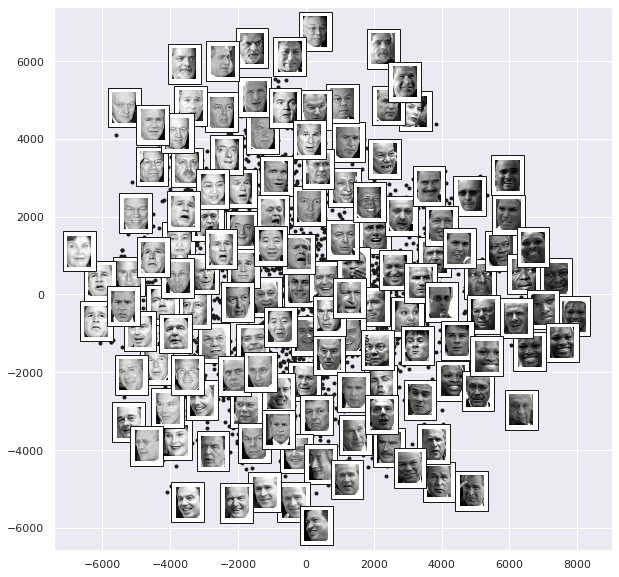

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
plot_components(faces.data,
                model=Isomap(n_components=2),
                images=faces.images[:, ::2, ::2])

### P.480

## Example: Visualizing Structure in Digits

As another example of using manifold learning for visualization, let's take a look at the MNIST handwritten digits set.
This data is similar to the digits we saw in [In-Depth: Decision Trees and Random Forests](05.08-Random-Forests.ipynb), but with many more pixels per image.
It can be downloaded from http://mldata.org/ with the Scikit-Learn utility:

In [ ]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784')
mnist.data.shape

(70000, 784)

This consists of 70,000 images, each with 784 pixels (i.e. the images are 28×28).
As before, we can take a look at the first few images:

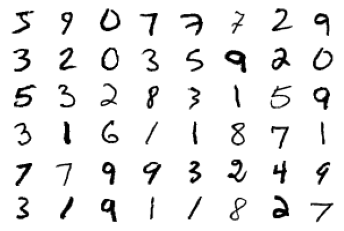

In [ ]:
fig, ax = plt.subplots(6, 8, subplot_kw=dict(xticks=[], yticks=[]))
for i, axi in enumerate(ax.flat):
    axi.imshow(mnist.data[1250 * i].reshape(28, 28), cmap='gray_r')

### P.481

In [ ]:
def fullprint(*args, **kwargs):
  from pprint import pprint
  import numpy
  opt = numpy.get_printoptions()
  numpy.set_printoptions(threshold=numpy.inf)
  pprint(*args, **kwargs)
  numpy.set_printoptions(**opt)

In [ ]:
# use only 1/30 of the data: full dataset takes a long time!
data = mnist.data[::30]
target = mnist.target[::30]
target.data.shape

(2334,)

In [ ]:
type(target)

numpy.ndarray

In [ ]:
fullprint(target)

array(['5', '3', '4', '6', '2', '4', '2', '0', '8', '1', '8', '3', '2',
       '2', '5', '1', '5', '1', '3', '2', '9', '6', '6', '5', '8', '7',
       '1', '6', '3', '1', '9', '9', '5', '4', '6', '4', '1', '4', '2',
       '8', '1', '1', '3', '3', '3', '6', '4', '9', '4', '3', '9', '0',
       '9', '0', '9', '5', '1', '1', '9', '7', '2', '6', '1', '6', '2',
       '9', '6', '2', '1', '8', '0', '3', '0', '4', '4', '5', '2', '0',
       '0', '9', '8', '3', '9', '4', '4', '2', '3', '8', '9', '2', '2',
       '1', '3', '2', '3', '6', '6', '6', '8', '1', '9', '9', '7', '9',
       '1', '3', '5', '7', '4', '7', '2', '6', '4', '2', '8', '4', '8',
       '9', '1', '8', '8', '8', '2', '8', '0', '7', '7', '3', '7', '5',
       '1', '2', '6', '4', '7', '9', '2', '6', '1', '6', '7', '2', '9',
       '5', '9', '9', '2', '4', '8', '1', '0', '7', '6', '5', '6', '2',
       '7', '1', '3', '6', '6', '9', '8', '4', '1', '1', '6', '0', '6',
       '6', '7', '9', '3', '3', '8', '2', '7', '6', '0', '3', '2

In [ ]:
target.dtype
# 原是Object，要改變性質成int64方能使用(課本的沒寫)

dtype('O')

In [ ]:
target = target.astype('int64')

In [ ]:
target.dtype

dtype('int64')

In [ ]:
fullprint(target)

array([5, 3, 4, 6, 2, 4, 2, 0, 8, 1, 8, 3, 2, 2, 5, 1, 5, 1, 3, 2, 9, 6,
       6, 5, 8, 7, 1, 6, 3, 1, 9, 9, 5, 4, 6, 4, 1, 4, 2, 8, 1, 1, 3, 3,
       3, 6, 4, 9, 4, 3, 9, 0, 9, 0, 9, 5, 1, 1, 9, 7, 2, 6, 1, 6, 2, 9,
       6, 2, 1, 8, 0, 3, 0, 4, 4, 5, 2, 0, 0, 9, 8, 3, 9, 4, 4, 2, 3, 8,
       9, 2, 2, 1, 3, 2, 3, 6, 6, 6, 8, 1, 9, 9, 7, 9, 1, 3, 5, 7, 4, 7,
       2, 6, 4, 2, 8, 4, 8, 9, 1, 8, 8, 8, 2, 8, 0, 7, 7, 3, 7, 5, 1, 2,
       6, 4, 7, 9, 2, 6, 1, 6, 7, 2, 9, 5, 9, 9, 2, 4, 8, 1, 0, 7, 6, 5,
       6, 2, 7, 1, 3, 6, 6, 9, 8, 4, 1, 1, 6, 0, 6, 6, 7, 9, 3, 3, 8, 2,
       7, 6, 0, 3, 2, 8, 8, 4, 1, 5, 4, 1, 3, 8, 2, 0, 1, 2, 3, 1, 4, 6,
       9, 3, 6, 8, 2, 6, 4, 6, 5, 4, 8, 2, 5, 0, 2, 8, 3, 3, 2, 7, 2, 1,
       7, 0, 5, 6, 6, 3, 2, 4, 5, 1, 1, 6, 0, 4, 1, 0, 3, 9, 2, 2, 9, 6,
       5, 8, 8, 4, 7, 1, 1, 7, 2, 7, 4, 3, 9, 1, 9, 0, 5, 7, 3, 0, 1, 9,
       2, 7, 3, 5, 1, 1, 6, 7, 1, 5, 9, 0, 7, 8, 8, 4, 4, 1, 2, 2, 8, 1,
       4, 1, 2, 2, 3, 8, 1, 3, 6, 6, 3, 7, 6, 1, 6,

In [ ]:
t = np.arange(2334)
t.data.shape

(2334,)

In [ ]:
type(t)

numpy.ndarray

In [ ]:
t.dtype

dtype('int64')

In [ ]:
t.data.shape

(2334,)

In [ ]:
fullprint(t)

array([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
         11,   12,   13,   14,   15,   16,   17,   18,   19,   20,   21,
         22,   23,   24,   25,   26,   27,   28,   29,   30,   31,   32,
         33,   34,   35,   36,   37,   38,   39,   40,   41,   42,   43,
         44,   45,   46,   47,   48,   49,   50,   51,   52,   53,   54,
         55,   56,   57,   58,   59,   60,   61,   62,   63,   64,   65,
         66,   67,   68,   69,   70,   71,   72,   73,   74,   75,   76,
         77,   78,   79,   80,   81,   82,   83,   84,   85,   86,   87,
         88,   89,   90,   91,   92,   93,   94,   95,   96,   97,   98,
         99,  100,  101,  102,  103,  104,  105,  106,  107,  108,  109,
        110,  111,  112,  113,  114,  115,  116,  117,  118,  119,  120,
        121,  122,  123,  124,  125,  126,  127,  128,  129,  130,  131,
        132,  133,  134,  135,  136,  137,  138,  139,  140,  141,  142,
        143,  144,  145,  146,  147,  148,  149,  1

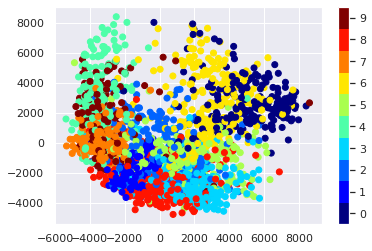

In [ ]:
model = Isomap(n_components=2)
proj = model.fit_transform(data)
plt.scatter(proj[:, 0], proj[:, 1], c=target, cmap=plt.cm.get_cmap('jet', 10))
plt.colorbar(ticks=range(10))
plt.clim(-0.5, 9.5);

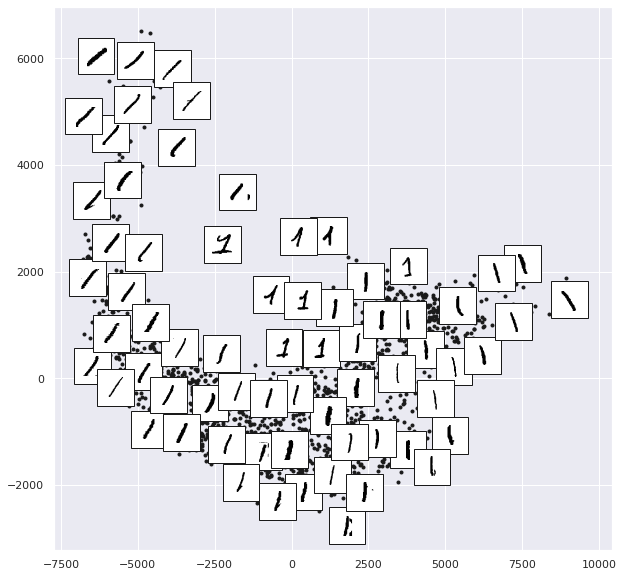

In [ ]:
from sklearn.manifold import Isomap

# Choose 1/4 of the "1" digits to project
data = mnist.data[mnist.target == '1'][::4]

fig, ax = plt.subplots(figsize=(10, 10))
model = Isomap(n_neighbors=5, n_components=2, eigen_solver='dense')
plot_components(data, model, images=data.reshape((-1, 28, 28)),
                ax=ax, thumb_frac=0.05, cmap='gray_r')